In [1]:
import numpy as np
import os
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import argparse
import torch
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import pyemma.msm as msm
from scipy.linalg import schur

from utils import _print, read_sparse_X, import_data, load_gene_matrix, setup_data_loaders
from utils import GeneMatrixDataset
from utils import train, evaluate, encode_data, decode_data, matrix_similarity
from vae_classes import Decoder, Encoder, VAE

/pool01/conda/envs/enrollhd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/pool01/conda/envs/enrollhd/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
# gene = 'WWOX'
# gene = 'DLG2'
# gene = 'FHIT'
# gene = 'MYT1L'
# gene = 'HTT'
gene = 'MSH2'
z_dim = 2
hidden_dim_percentage = 40
f_decoder = "Bernoulli"
beta = 1
lr = 0.001
use_cuda = False
num_epochs = 100
test_frequency = 10

In [3]:
# Change working directory
os.chdir('/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/')
# os.chdir('/home/ub/ub781464/')

# Input and output directories
data_dir = "features/"
biomart_dir = "biomart/"
output_dir = "vae/"
# data_dir = "data/enroll_hd/features/"
# biomart_dir = "data/enroll_hd/biomart/"
# output_dir = "data/enroll_hd/vae"

# Data path
# X_path = data_dir + "X_pc10_filt_0.01.txt"
# header_path = data_dir + "subsetting/header_X_pc10_filt_0.01.txt"

X_path = data_dir + "feature_matrix_m3_filt_0.01.txt"
header_path = data_dir + "subsetting/header_feature_matrix_m3_filt_0.01.txt"

lookuptab_path = biomart_dir + "revised_filtered_snp_gene_lookup_tab.txt"

train_indices_path = output_dir + "train_idxs_{}_zdim{}_hdim{}".format(gene, z_dim, hidden_dim_percentage)
test_indices_path = output_dir + "test_idxs_{}_zdim{}_hdim{}".format(gene, z_dim, hidden_dim_percentage)
    

In [4]:
# Obtain gene_matrix
X, lookuptab, header = import_data(X_path=X_path, 
                                    lookuptab_path=lookuptab_path,
                                    header_path=header_path)

In [ ]:
# Subset feature matrix
gene_matrix = load_gene_matrix(X, lookuptab, header, gene = gene)

In [7]:
unique_values, counts = np.unique(gene_matrix, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f'Value {value} occurs {count} times')

Value 0.0 occurs 37831632 times
Value 1.0 occurs 8652465 times
Value 2.0 occurs 1709191 times


In [7]:

# Variable that stores input size (number of SNPs in gene)
g_length = gene_matrix.shape[1]

# Calculate dimensionality of hidden layer
hidden_dim = int(round(g_length * (hidden_dim_percentage/100), 0))

if f_decoder == "Bernoulli":
    # Normalize data between 0 and 1
    gene_matrix = gene_matrix*0.5

# setup data loaders
train_loader, test_loader = setup_data_loaders(train_indices_path, test_indices_path,
                                                gene_matrix, batch_size=128, use_cuda=use_cuda)


## Correlation matrix between gene SNPs

In [8]:
gene = 'HTT'
gene_matrix = load_gene_matrix(X, lookuptab, header, gene)

In [9]:
# Create a DataFrame
snps_df = pd.DataFrame(gene_matrix)

# Compute the correlation matrix
snps_corr_matrix = snps_df.corr()

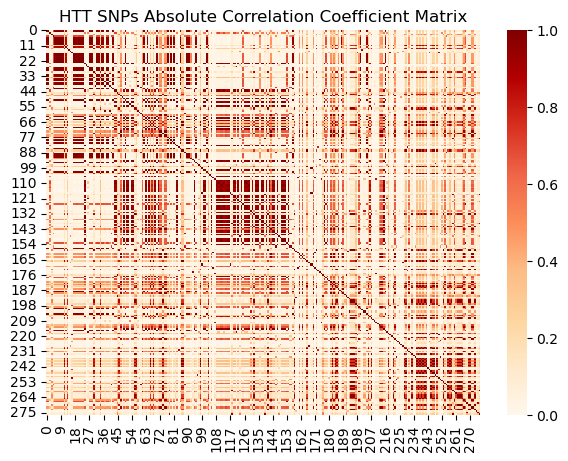

In [10]:
# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(abs(snps_corr_matrix), cmap='OrRd', vmin=0, vmax=1)
plt.title('{} SNPs Absolute Correlation Coefficient Matrix'.format(gene))
plt.show()

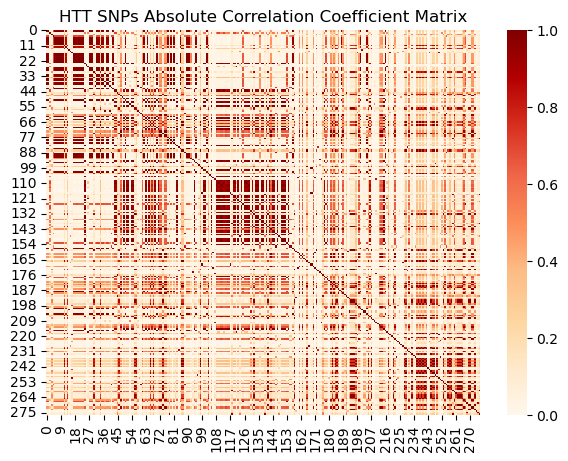

In [11]:
# Rasterize the heatmap and save it to a PDF
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

# Create the heatmap and rasterize only the heatmap (not text)
sns_heatmap = sns.heatmap(abs(snps_corr_matrix), cmap='OrRd', vmin=0, vmax=1, ax=ax)

# Rasterize only the heatmap quadmesh, leave text/vector graphics
sns_heatmap.collections[0].set_rasterized(True)

plt.title('{} SNPs Absolute Correlation Coefficient Matrix'.format(gene))

# Save to PDF with rasterized image inside
plt.savefig(f"{output_dir}{gene}_abs_corr_matrix.pdf", dpi=300)
plt.show()

## Eigenvalues of correlation matrix obtained from schur decomposition

In [12]:
# Compute the Schur decomposition
T, Q = schur(abs(snps_corr_matrix))

# Extract the eigenvalues from the diagonal of T
eigenvalues = np.diag(T)

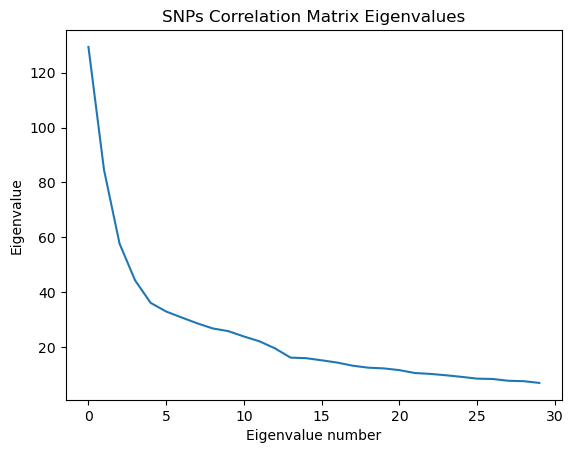

In [32]:
# Plot eigenvalues
plt.plot(eigenvalues[:30])
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue")
plt.title("SNPs Correlation Matrix Eigenvalues")
plt.show()

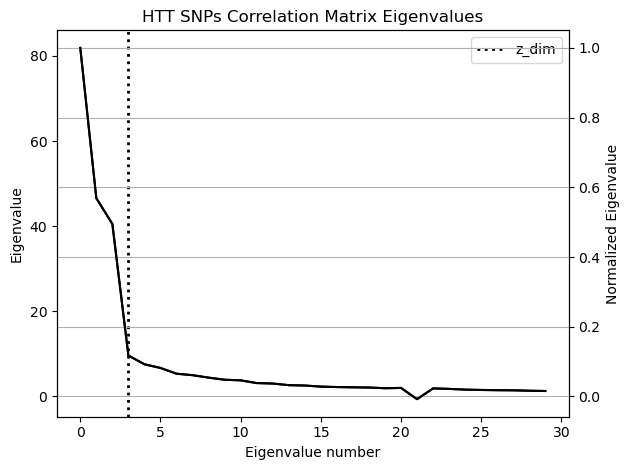

In [14]:
# Find how many eigenvalues to take as z_dim

# Normalize eigenvalues
norm_eigens = eigenvalues / max(eigenvalues)

# Determine z_dim
threshold = 0.2
z_dim = sum(norm_eigens >= threshold)

fig, ax1 = plt.subplots()

# Left y-axis: raw eigenvalues
ax1.plot(eigenvalues[:30], color='black')
ax1.set_xlabel("Eigenvalue number")
ax1.set_ylabel("Eigenvalue", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Right y-axis: normalized eigenvalues
ax2 = ax1.twinx()
ax2.plot(norm_eigens[:30], color='black', linestyle='-')
ax2.set_ylabel("Normalized Eigenvalue", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Vertical line at eigenvalue number 9
ax1.axvline(x=z_dim, color='black', linestyle=':', linewidth=2, label='z_dim')

plt.title(f"{gene} SNPs Correlation Matrix Eigenvalues")
ax1.legend(loc='upper right')
plt.grid()
fig.tight_layout()
plt.savefig(f"{output_dir}{gene}_eigenvalues.pdf", dpi=300)
plt.show()

In [16]:
# Sort eigenvalues by their absolute magnitudes
abs_eigenvalues = np.abs(eigenvalues)
sorted_idxs = np.argsort(abs_eigenvalues)[::-1]  # Sort in descending order
sorted_eigenvalues = abs_eigenvalues[sorted_idxs]

# Compute cumulative sum of the absolute eigenvalues
cumulative_sum = np.cumsum(sorted_eigenvalues)

# Calculate total sum of eigenvalues and threshold
total_sum = np.sum(sorted_eigenvalues)
threshold = 0.80 * total_sum 

# Find the number of eigenvalues needed to reach the threshold
n_eigenvalues = np.searchsorted(cumulative_sum, threshold) + 1

In [21]:
n_eigenvalues

456

## Transition matrix

In [21]:
# Normalize correlation absolute values to obtain transition probabilities
normed_matrix = normalize(abs(snps_corr_matrix), axis=1, norm='l1')

In [22]:
# Create a Markov state model (MSM)
msm_model = msm.markov_model(normed_matrix)

In [23]:
# Perform GPCCA to identify metastable states
n_metastable_states = 6
gpcca = msm_model.pcca(n_metastable_states)

/media/HDD_4TB_1/jordi/miniconda3/envs/enrollhd_jupyter/lib/python3.11/site-packages/deeptime/markov/tools/analysis/dense/_pcca.py:259: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


In [27]:
gene_matrix.shape

(9064, 277)

In [24]:
# Coarse-grained transition matrix
P_coarse = gpcca.coarse_grained_transition_matrix

# Memberships of each state in the metastable sets
memberships = gpcca.memberships

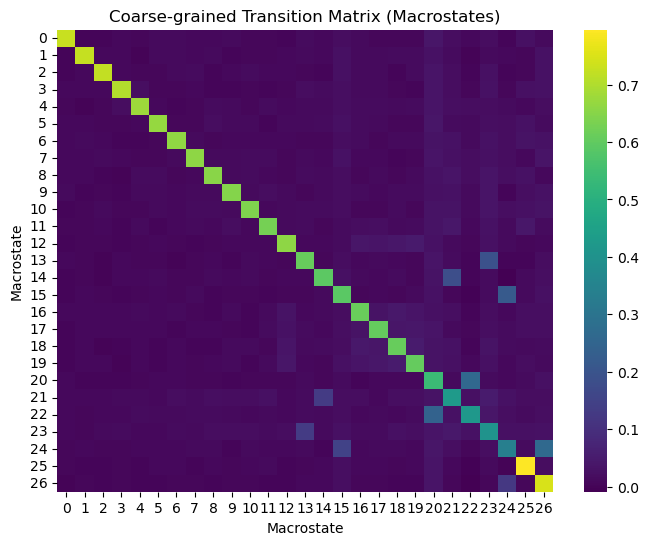

In [22]:
# Plot heatmap of the coarse-grained transition matrix (macrostates)
plt.figure(figsize=(8, 6))
sns.heatmap(P_coarse, cmap='viridis', cbar=True)
plt.title('Coarse-grained Transition Matrix (Macrostates)')
plt.xlabel('Macrostate')
plt.ylabel('Macrostate')
plt.show()

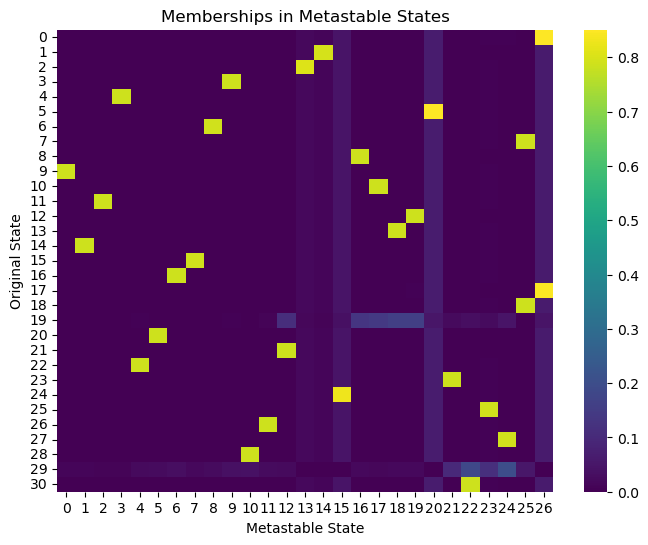

In [28]:
# Plot heatmap of the memberships
plt.figure(figsize=(8, 6))
sns.heatmap(memberships, cmap='viridis', cbar=True)
plt.title('Memberships in Metastable States')
plt.xlabel('Metastable State')
plt.ylabel('Original State')
plt.show()

In [ ]:
gene_matrix.shape

(900, 624)

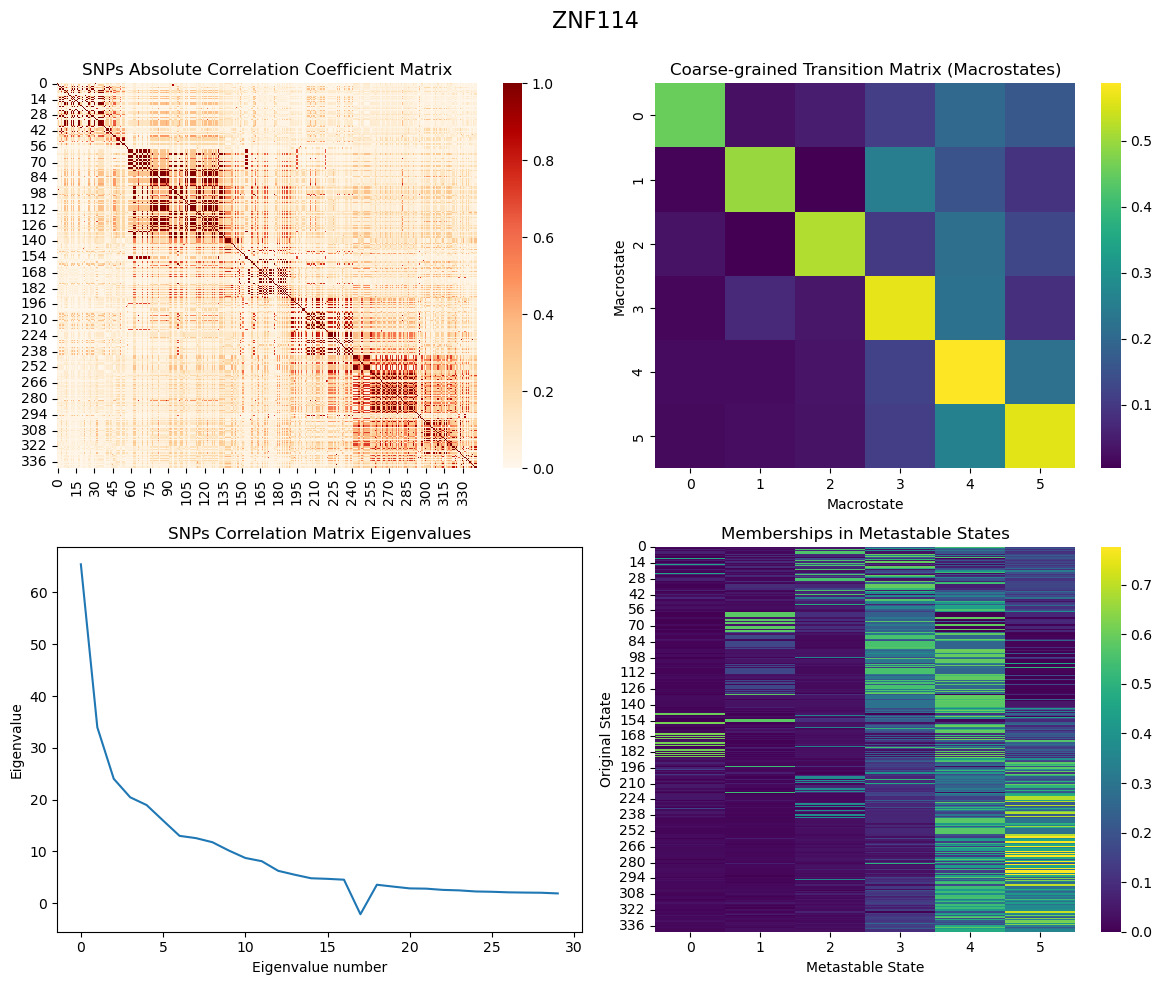

In [25]:
fig, axes = plt.subplots(2,2, figsize=(12, 10))

fig.suptitle(gene, fontsize=16)

# Unpack axes from the 2x2 array
ax11, ax12 = axes[0]
ax21, ax22 = axes[1]

# Correlation matrix
sns.heatmap(abs(snps_corr_matrix), cmap='OrRd', vmin=0, vmax=1, ax=ax11)
ax11.set_title('SNPs Absolute Correlation Coefficient Matrix')

# Plot eigenvalues
ax21.plot(eigenvalues[:30])
ax21.set_xlabel("Eigenvalue number")
ax21.set_ylabel("Eigenvalue")
ax21.set_title("SNPs Correlation Matrix Eigenvalues")

# Plot heatmap of the coarse-grained transition matrix (macrostates)
sns.heatmap(P_coarse, cmap='viridis', cbar=True, ax=ax12)
ax12.set_title('Coarse-grained Transition Matrix (Macrostates)')
ax12.set_xlabel('Macrostate')
ax12.set_ylabel('Macrostate')

# Plot heatmap of the memberships
sns.heatmap(memberships, cmap='viridis', cbar=True, ax = ax22)
ax22.set_title('Memberships in Metastable States')
ax22.set_xlabel('Metastable State')
ax22.set_ylabel('Original State')

plt.tight_layout(rect=[0, 0, 1, 0.98]) 

plt.show()

## Correlation with latent space

In [ ]:
beta = 1.5

In [ ]:
# setup the VAE
vae = VAE(z_dim = z_dim, hidden_dim = hidden_dim, 
            gene_length = g_length, 
            f_dec = f_decoder, beta=beta, 
            use_cuda=use_cuda)

# setup the optimizer
optimizer = Adam({"lr": lr})

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []

# training loop
for epoch in range(num_epochs):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=use_cuda)
    train_elbo.append(-total_epoch_loss_train)
    # print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % test_frequency == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=use_cuda)
        test_elbo.append(-total_epoch_loss_test)
        # print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))


# Encode and decode gene_matrix
encoded_data = encode_data(vae, gene_matrix, use_cuda= use_cuda)

In [ ]:
# Create an empty matrix to store the correlations
correlation_matrix = np.empty((encoded_data.shape[1], gene_matrix.shape[1]))

# Compute the correlation for each column in encoded_matrix
for i in range(encoded_data.shape[1]):
    encoded_col = encoded_data[:, i]
    for j in range(gene_matrix.shape[1]):
        gene_col = gene_matrix[:, j]
        # Compute Pearson correlation coefficient
        correlation = np.corrcoef(encoded_col, gene_col)[0, 1]
        correlation_matrix[i, j] = correlation

In [ ]:
z_snps_corr = abs(correlation_matrix)

In [ ]:
# Define the window size
window_size = 120

# Calculate the running mean for each row
def running_mean(arr, window_size):
    cumsum = np.cumsum(arr, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

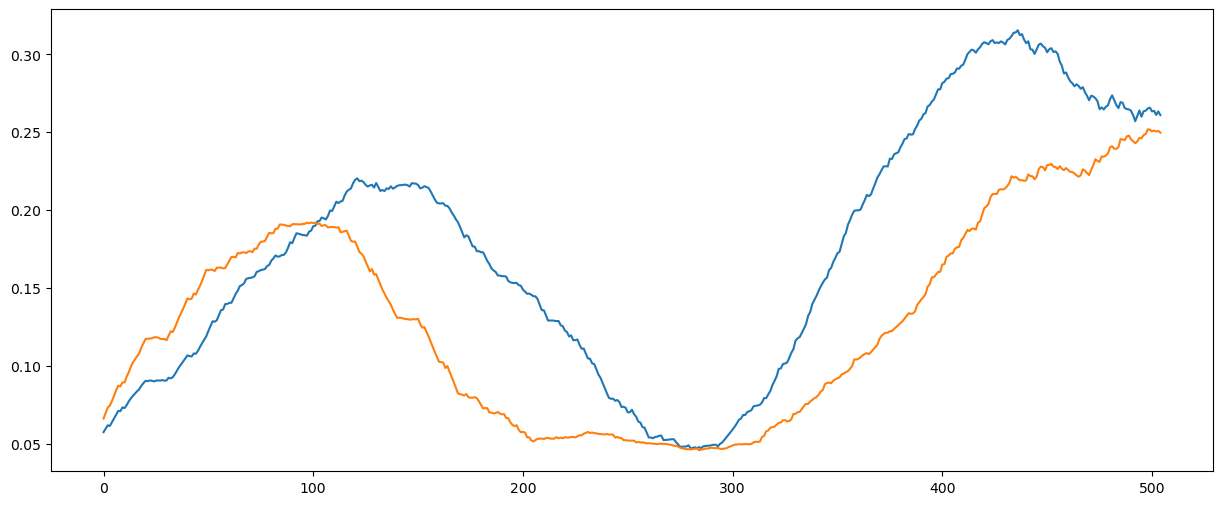

In [ ]:
z1 = running_mean(z_snps_corr[0,:], window_size)
z2 = running_mean(z_snps_corr[1,:], window_size)

plt.figure(figsize=(15,6))
plt.plot(z1)
plt.plot(z2)
plt.show()

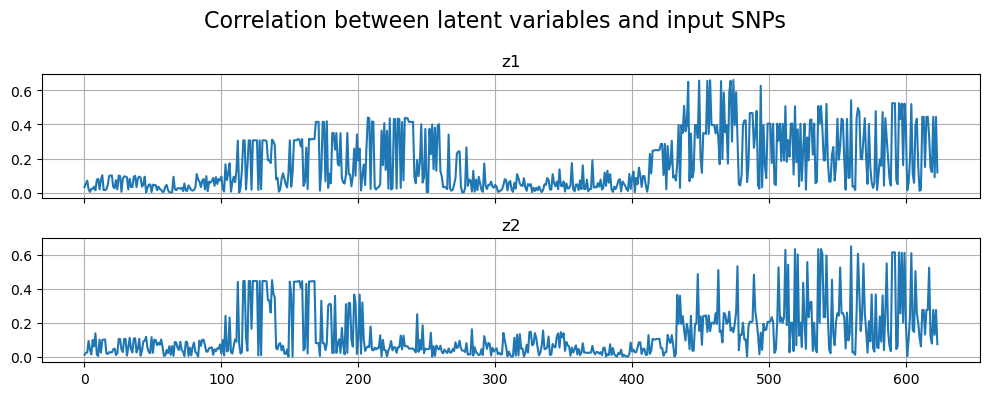

In [ ]:
# Number of rows and columns in the matrix
num_rows, num_cols = z_snps_corr.shape

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, 2*num_rows), sharex=True, sharey=True)

# Plot each row in a subplot
for i in range(num_rows):
    axes[i].plot(z_snps_corr[i, :])
    axes[i].set_title(f'z{i+1}')
    axes[i].grid(True)

fig.suptitle("Correlation between latent variables and input SNPs", fontsize=16)


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Create a DataFrame
encoded_df = pd.DataFrame(encoded_data)

# Compute the correlation matrix
encoded_corr_matrix = encoded_df.corr()

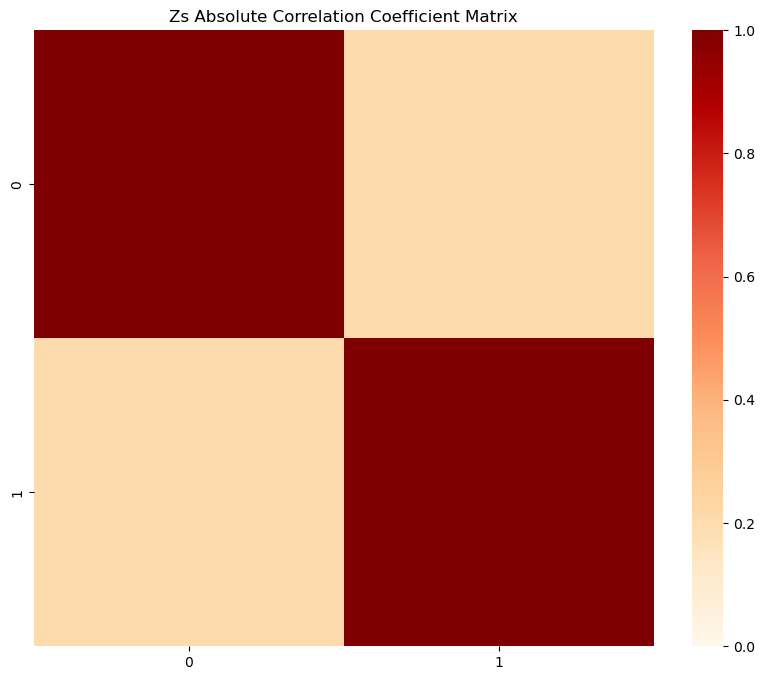

In [ ]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(abs(encoded_corr_matrix), cmap='OrRd', vmin=0, vmax=1)
plt.title('Zs Absolute Correlation Coefficient Matrix')
plt.show()

In [ ]:
x = torch.tensor(gene_matrix)

In [ ]:
decoded_data = vae.reconstruct_vec(x)

In [ ]:
decoded_data = decoded_data.detach().numpy()

In [ ]:
# Define the bin edges and bin labels
bins = np.array([0, 1/3, 2/3, 1])  # Bin edges
bin_labels = np.array([0, 0.5, 1])  # Corresponding bin labels

# Flatten the matrix for vectorized operations
flattened_data = decoded_data.flatten()

# Use numpy to find the bin indices for each value
# Ensure that values exactly equal to the upper edge of the last bin get the last label
bin_indices = np.searchsorted(bins, flattened_data, side='right') - 1
bin_indices = np.clip(bin_indices, 0, len(bin_labels) - 1)

# Map bin indices to bin labels
binned_flattened_data = bin_labels[bin_indices]

# Reshape back to the original matrix shape
binned_matrix = binned_flattened_data.reshape(decoded_data.shape)

Text(0, 0.5, 'Sample')

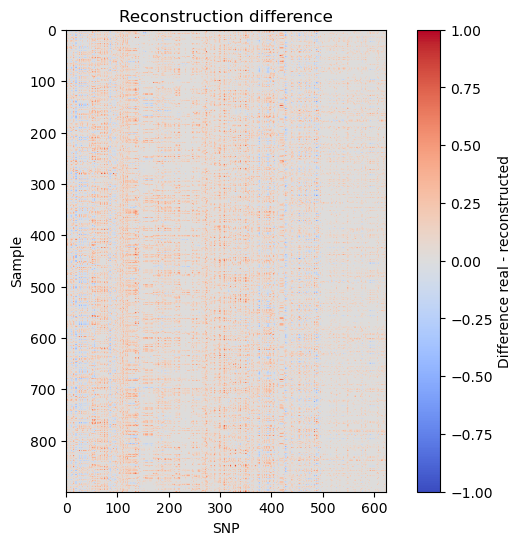

In [ ]:
# Difference matrix
diff = gene_matrix - binned_matrix

# Normalize to be comparable to Bernoulli results
if f_decoder == "Categorical":
    diff = diff * 0.5

# Define a custom colormap from -2 to 2
cmap = plt.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=-1, vmax=1)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(diff, cmap=cmap, norm=norm)
fig.colorbar(cax, label='Difference real - reconstructed')

# Add labels and title for better understanding
ax.set_title('Reconstruction difference'.format(gene, z_dim, hidden_dim))
ax.set_xlabel('SNP')
ax.set_ylabel('Sample')
